In [1]:
# script to save the rankings for the mechanism
import os
import sys
import glob
import pickle
import numpy as np
import pandas as pd

import rmgpy.chemkin

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline


sys.path.append('/home/moon/autoscience/reaction_calculator/database/')
import importlib
import database_fun

from matplotlib.patches import Circle
import matplotlib.offsetbox
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

import matplotlib.image as mpimg


In [2]:
# Load the experimental conditions
ignition_delay_data = '/home/moon/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * 101325.0  # pressures in atm

In [3]:
mech_dir = '/home/moon/autoscience/fuels/butane_20240501'

# Load the analysis files
analysis_dir = os.path.join(mech_dir, 'analysis')
total_uncertainty_mat = np.load(os.path.join(analysis_dir, 'total_uncertainty_mat.npy'))
dft_uncertainty_mat = np.load(os.path.join(analysis_dir, 'dft_uncertainty_mat.npy'))
first_derivative = np.load(os.path.join(analysis_dir, 'first_derivative.npy'))
improvement_score = np.load(os.path.join(analysis_dir, 'improvement_score.npy'))
base_delay_file = os.path.join(mech_dir, 'total_base_delays.npy')
base_delays = np.load(base_delay_file)
with open(os.path.join(mech_dir, 'ct2rmg_rxn.pickle'), 'rb') as f:
    ct2rmg_rxn = pickle.load(f)

# Compute local uncertainty
delta_uncertainty_squared = np.float_power(total_uncertainty_mat, 2.0) - np.float_power(dft_uncertainty_mat, 2.0)
sensitivity_squared = np.float_power(first_derivative, 2.0)
improvement_score = np.multiply(delta_uncertainty_squared, sensitivity_squared)
avg_improvement_score = np.nanmean(improvement_score, axis=1)
avg_improvement_score[np.isnan(avg_improvement_score)] = -np.inf
improvement_score[np.isnan(improvement_score)] = -np.inf
total_uncertainty_squared = np.nansum(np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)), axis=0)
total_uncertainty = np.array(np.float_power(total_uncertainty_squared, 0.5)).ravel()

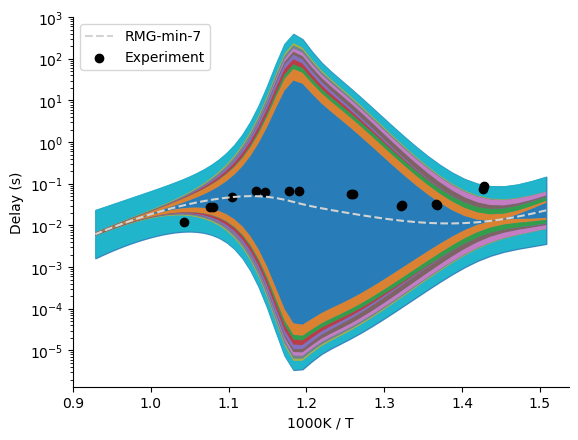

In [23]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
alpha = 0.8

# fetch the Table 7 results
Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
Tmin = 663
K = 51
temperatures = np.linspace(Tmin, Tmax, K)

table_index = 7

# Plot the local uncertainty
total_uncertainty7 = np.array(total_uncertainty[(table_index - 1) * K: table_index * K])
base_delays7 = base_delays[(table_index - 1) * K: table_index * K]
upper_bound_stddev = np.exp(np.log(base_delays7) + total_uncertainty7)
lower_bound_stddev = np.exp(np.log(base_delays7) - total_uncertainty7)
plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev, alpha=alpha, color=colors[0])
plt.fill_between(1000.0 / temperatures, lower_bound_stddev, base_delays7, alpha=alpha, color=colors[0])

# get the plotting order
uncertainty_7_squared = np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0))[:, (table_index - 1) * K: table_index * K]
total_uncertainty_7_squared = np.nansum(uncertainty_7_squared, axis=0)
u_2 = uncertainty_7_squared[:, 20]
indices = np.arange(len(u_2))
param_order = [x for _, x in sorted(zip(u_2, indices))][::-1]

M = 10  # how many components to draw
# Calculate the uncertainty components
lumped_uncertainty_7_squared = np.zeros((M, K))
lumped_uncertainty_percentages = np.zeros((M, K))
for i in range(M - 1):
    lumped_uncertainty_7_squared[i, :] = uncertainty_7_squared[param_order[i], :]
    lumped_uncertainty_percentages[i, :] = np.divide(lumped_uncertainty_7_squared[i, :], total_uncertainty_7_squared)
    uncertainty_7_squared[param_order[i], :] = np.zeros(K)

# group whatever's left into a single category    
lumped_uncertainty_7_squared[-1, :] = np.nansum(uncertainty_7_squared, axis=0)
lumped_uncertainty_percentages[-1, :] = np.divide(lumped_uncertainty_7_squared[-1, :], total_uncertainty_7_squared)

# plot the nominal RMG-min-7 ignition delay values
plt.plot(1000.0 / temperatures, base_delays7, color='lightgrey', label='RMG-min-7', linestyle='dashed')

# make a list of the borders between uncertainty components
upward_bounds = np.zeros((M + 1, K))
downward_bounds = np.zeros((M + 1, K))
upward_bounds[0, :] = base_delays7
downward_bounds[0, :] = base_delays7

# Plot the uncertainty components
for i in range(1, M):
    upward_bounds[i, :] = np.exp(np.log(base_delays7) + np.multiply(np.sum(lumped_uncertainty_percentages[:i, :], axis=0), total_uncertainty7))
    downward_bounds[i, :] = np.exp(np.log(base_delays7) - np.multiply(np.sum(lumped_uncertainty_percentages[:i, :], axis=0), total_uncertainty7))
    plt.fill_between(1000.0 / temperatures, upward_bounds[i - 1, :], upward_bounds[i, :], alpha=alpha, color=colors[(i - 1) % len(colors)], label='_no_legend', edgecolor=None)
    plt.fill_between(1000.0 / temperatures, downward_bounds[i, :], downward_bounds[i - 1, :], alpha=alpha, color=colors[(i - 1) % len(colors)], edgecolor=None)

# Plot the "everything else" category
plt.fill_between(1000.0 / temperatures, upward_bounds[M - 1, :], upper_bound_stddev, alpha=alpha, color=colors[(M - 1)%len(colors)], label='_no_legend', edgecolor=None)
plt.fill_between(1000.0 / temperatures, lower_bound_stddev, downward_bounds[M - 1, :], alpha=alpha, color=colors[(M - 1)%len(colors)], edgecolor=None)

# Plot the experimental values for reference
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')
# plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='All Others')  # <--- use this to get "All Others" label in the matching font

ax = plt.gca()
ax.set_yscale('log')
plt.xlabel('1000K / T')
plt.ylabel(r'Delay (s)')
plt.legend(loc='upper left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))
ax.set_yticks([1.E-5,1.E-4,1.E-3,1.E-2,1.E-1,1.E0,1.E1,1.E2,1.E3])

plt.savefig('uncertainty_components.svg', bbox_inches='tight')

# Show the top parameters contributing to uncertainty

In [9]:
# load the RMG mechanism
chemkin = os.path.join(mech_dir, 'chem_annotated.inp')
sp_dict = os.path.join(mech_dir, 'species_dictionary.txt')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin, sp_dict)

In [20]:
# Make images for each of the top parameters
N_sp = len(param_order) - len(ct2rmg_rxn)
M_rxn = len(ct2rmg_rxn)

img_files = []
print('Rank\tParameter')
print('---------------------------------------------')
for i in range(0, 10):
    if param_order[i] < N_sp:
        print(f'{i + 1}\t{species_list[param_order[i]]}')
        
#         sp_file = f'component_{i:04}.png'
        sp_file = f'component_{i:04}.svg'
        species_list[param_order[i]].molecule[0].draw(sp_file)
        img_files.append(sp_file)
    else:
        rmg_index = ct2rmg_rxn[param_order[i] - N_sp]
        print(f'{i + 1}\t{reaction_list[rmg_index]}')
        
        # make reaction images for y axis labels
#         rxn_file = f'component_{i:04}.png'
        rxn_file = f'component_{i:04}.svg'
        reaction_list[rmg_index].draw(rxn_file)
        img_files.append(rxn_file)



Rank	Parameter
---------------------------------------------
1	O2(2) + [CH2]CC(C)OO(108) <=> S(229)
2	O2(2)
3	S(229) <=> OH(15) + CC(=O)CCOO(170)
4	S(225) <=> OH(15) + S(252)
5	S(225)
6	OH(15) + butane(1) <=> H2O(8) + PC4H9(182)
7	S(229)
8	HO2(16) + C4H8(188) <=> S(184)
9	HO2(16)
10	C4H8(188)
